# Fitting a Kepler Eclipsing Binary

In [1]:
get_ipython().magic('config InlineBackend.figure_format = "retina"')
import pandas as pd
import numpy as np
import statistics
import lightkurve as lk
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pylab as plt
import exoplanet as xo
import logging
import warnings
import transitleastsquares as tls

In [23]:
# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Remove when arviz is updated
warnings.filterwarnings("ignore", category=UserWarning)
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)
logger = logging.getLogger("exoplanet")
logger.setLevel(logging.DEBUG)

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 16
plt.rcParams['font.sans-serif'] = ['Arial']
c_lc = 'lightsteelblue'

## Download and Prepare the Photometric Data

In [3]:
def load_kepler_lc(name):
    data = lk.search_lightcurvefile(
        'KIC%s'%name, 
        cadence = 'short',
        mission = 'kepler').download_all()
    
    lc_data = data.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3, sigma_lower = float('inf'))
    tformat = lc_data.time_format
    return lc_data, tformat

def simplify_lc(lc, P, ntransits):
    middle_value = statistics.median(lc.time) 
    ndays = np.round(ntransits*P)
    mask_binning = (lc.time>middle_value) & (lc.time<middle_value+ndays)

    cut_lc = lk.LightCurve(
        time=lc.time[mask_binning == True], 
        flux=lc.flux[mask_binning == True], 
        flux_err = lc.flux_err[mask_binning == True], 
        time_format = tformat)
    
    return cut_lc

In [4]:
def prepare_lc_for_mcmc(data):
    lc_x = np.ascontiguousarray(data.time, dtype=np.float64)
    lc_y = np.ascontiguousarray(data.flux, dtype=np.float64)
    lc_yerr = np.ascontiguousarray(data.flux_err, dtype=np.float64)
    lc_mu = np.median(lc_y)
    
    lc_y = (lc_y / lc_mu - 1) * 1e3 #Units: Relative Flux [ppt]
    lc_yerr = lc_yerr * 1e3 / lc_mu
    
    return lc_x, lc_y, lc_yerr, lc_mu

In [5]:
KIC = 4544587
kepler_tref = 2454833
villanova_tref = 2400000 
texp = 58.9 / 60. / 60. / 24. 

First, let's define some values from the literature that will be useful below.

In [20]:
######## from Villanova EB database ########
lit_period = 2.1890973
lit_t0 = 54954.135787 + villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
R_A = 2.416
pdepth = 0.4479 #in flux units
sdepth = 0.324  #in flux units
pwidth = 2*0.1724  #in Phase units (it seems to be half the duration of the eclipse, so we multiply it by 2)
swidth = 2*0.1292  #in Phase units (it seems to be half the duration of the eclipse, so we multiply it by 2)

In [7]:
# from https://arxiv.org/pdf/1306.1819.pdf ########
R_B = 1.58  
a_prior = 10.855 #[Rsun]
i = np.radians(87.9) #[degrees] 
e = 0.275 
omega = 5.74 #[rad]

Then we'll download the Kepler data. 

In [8]:
ntransits = 2
kepler_lc, tformat = load_kepler_lc(KIC)
cut_lc = simplify_lc(kepler_lc, lit_period, ntransits)

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [9]:
x, y, yerr, mu = prepare_lc_for_mcmc(cut_lc)
lc_mcmc = lk.LightCurve(time=x, flux=y, flux_err=yerr)

### Plots

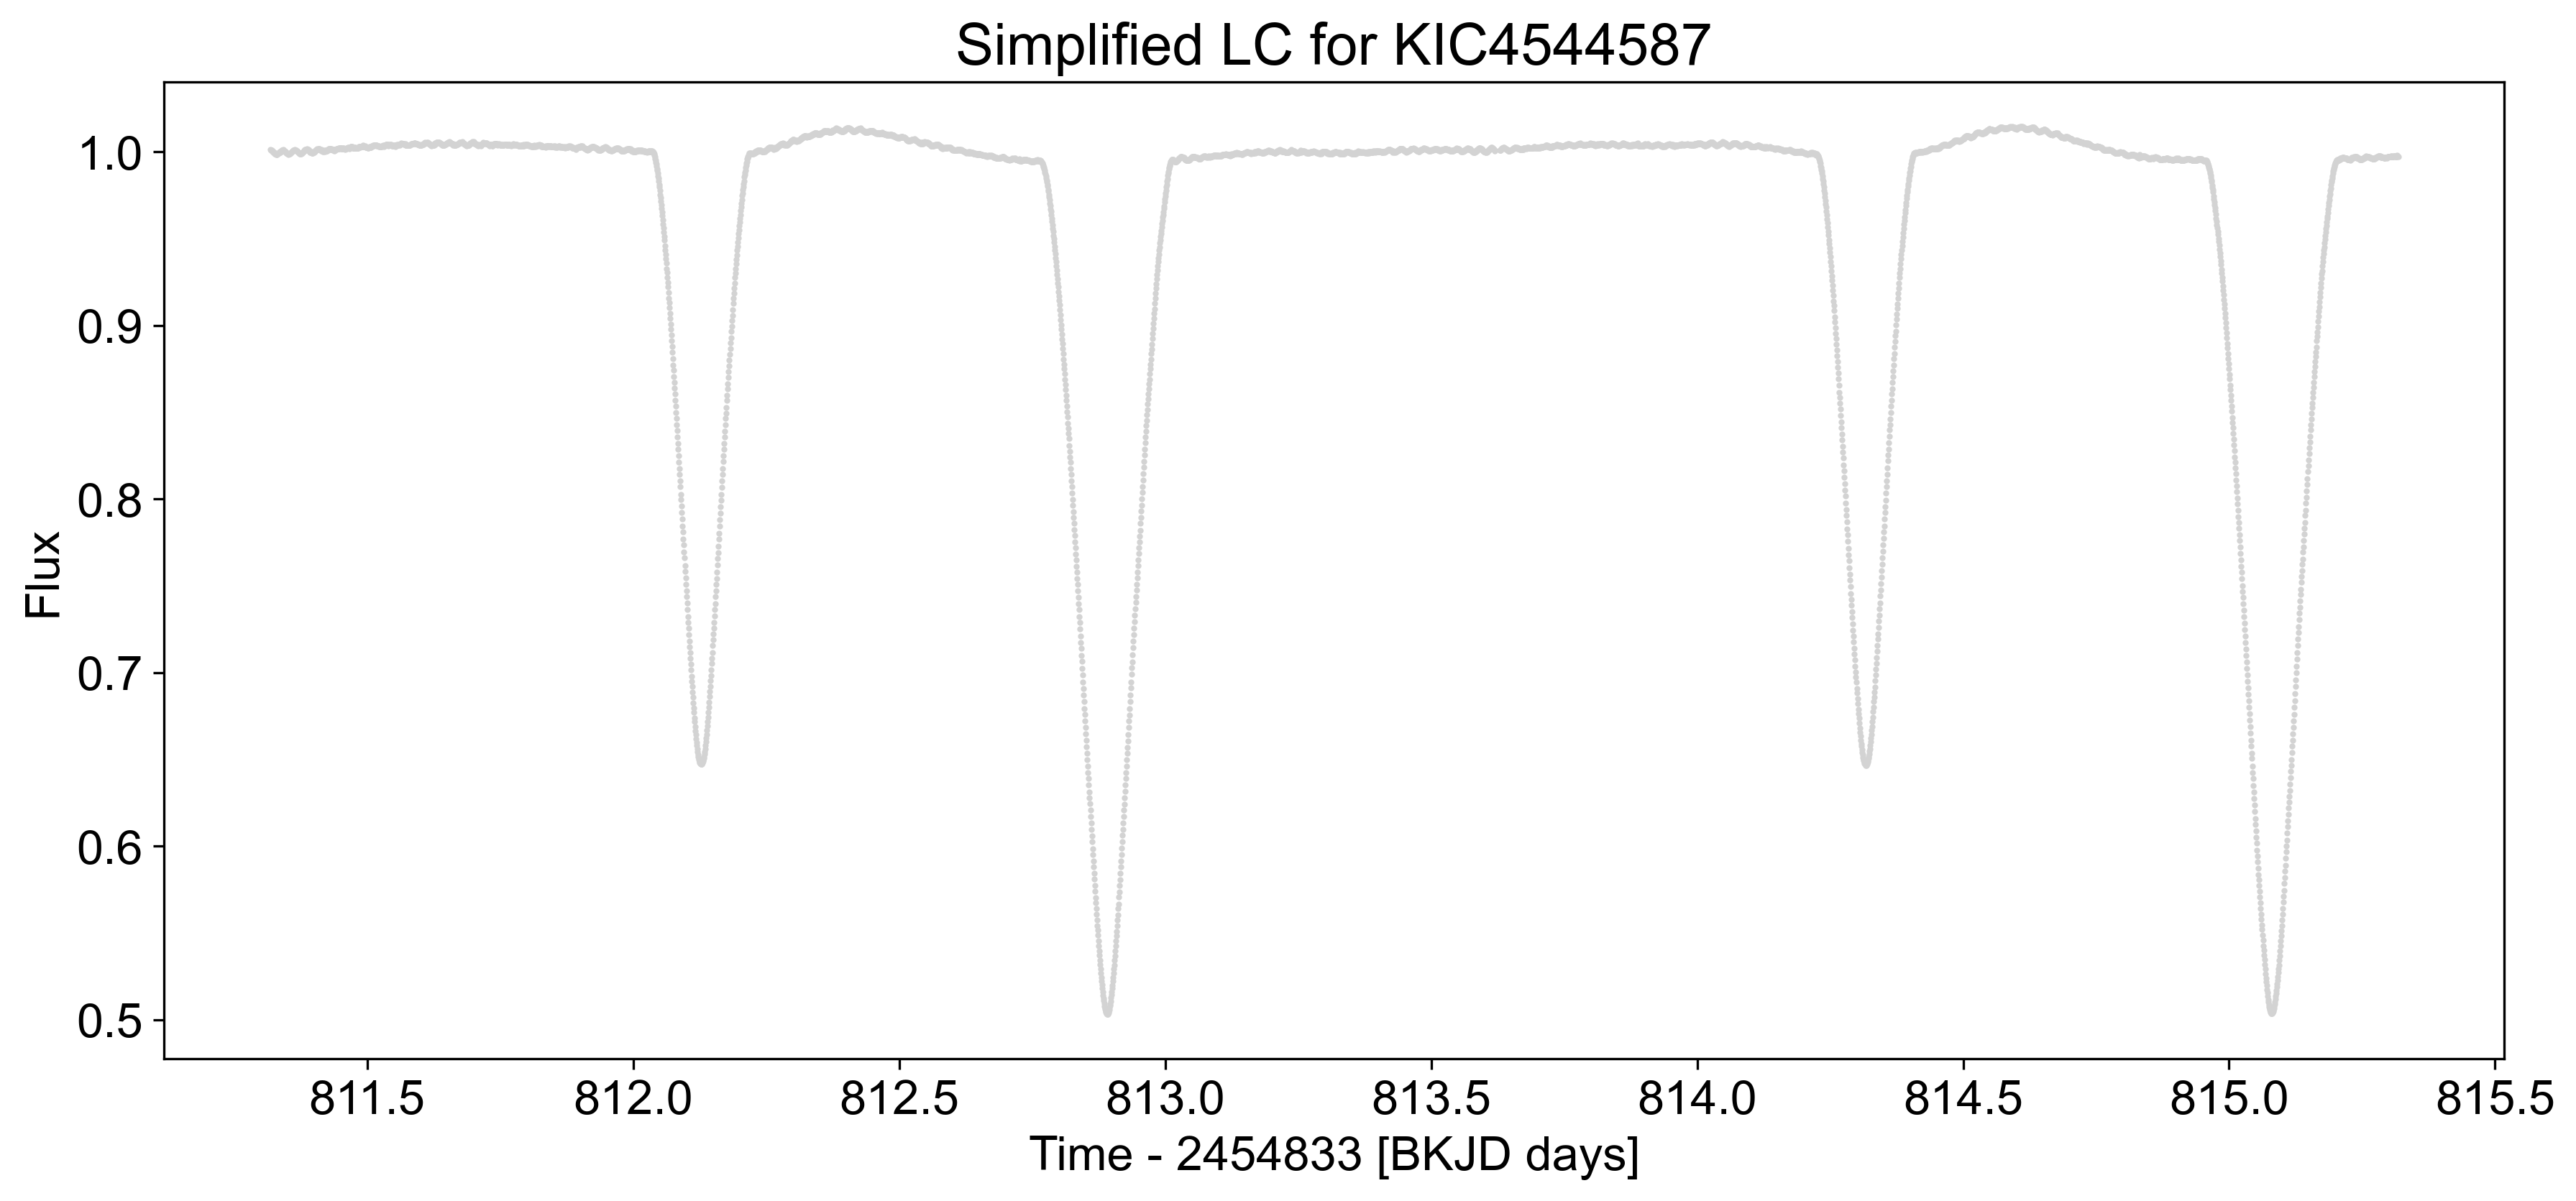

In [10]:
fig, ax = plt.subplots(1,1)
cut_lc.scatter(c = 'lightgrey', ax = ax)
ax.set(title = 'Simplified LC for KIC%s'%KIC);

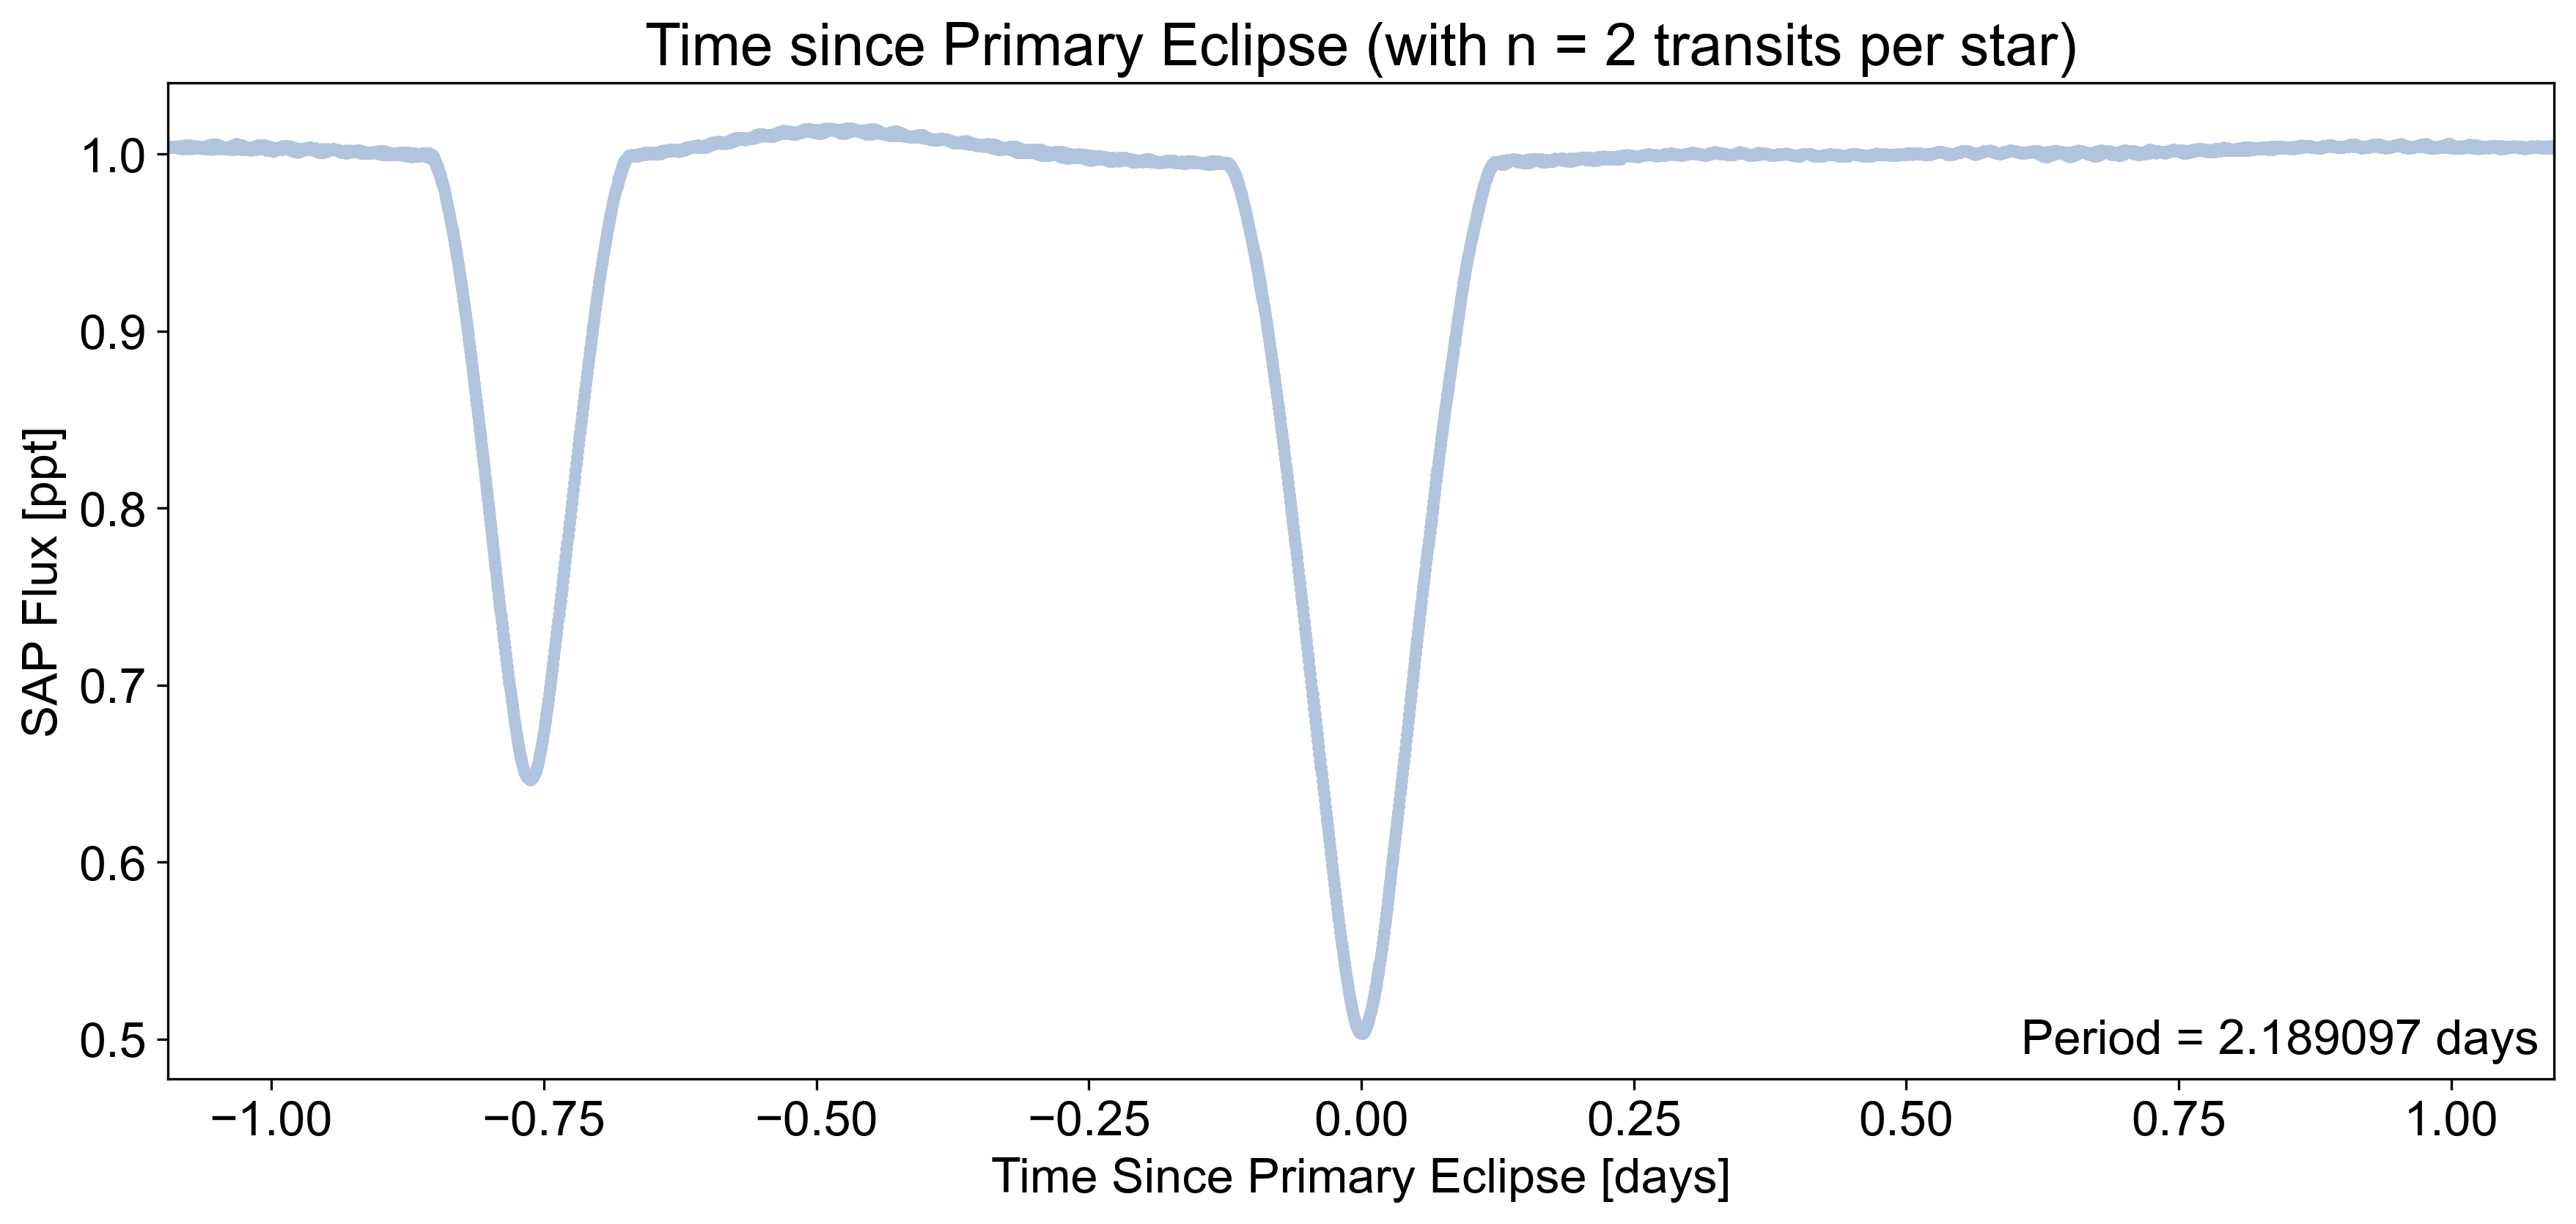

In [11]:
fig, ax = plt.subplots(1,1)
ax.scatter((cut_lc.time-lit_t0 + 0.5*lit_period) % lit_period-0.5*lit_period, cut_lc.flux, marker = ".", c = c_lc)
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period),
    xlabel = "Time Since Primary Eclipse [days]", 
    ylabel = "SAP Flux [ppt]",
    title = 'Time since Primary Eclipse (with n = %i transits per star)'%ntransits
);

ax.annotate(
    "Period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=16,
);

# Mask Transits

In [12]:
def summarize_tls_results(results):
    print(f'Period = {results.period:.5f} +/- {results.period_uncertainty:.5f} d')
    print('Transit depth = ', format(results.depth, '.5f'))
    print("T0 = ", format(results.T0, '.5f'))
    print('Best duration (days) = ', format(results.duration, '.5f'))
    print('Signal detection efficiency (SDE) = ', results.SDE)
    print('Signal-to-noise ratio (SNR) = ', results.snr)
    
def mask_transits(data, eclipse_duration, t0):
    intransit = tls.transit_mask(data.time, 
                                 lit_period, 
                                 transit_window*eclipse_duration*lit_period, 
                                 t0) #multiply the duration pwdith by P to convert it from phase units to days
    eclipses = data[intransit]
    lc_masked = data[~intransit]
    return lc_masked, eclipses

def get_t0_secondary(lc_primary_masked):
    KIC_params = tls.catalog_info(KIC_ID=KIC)
    ld, M_star, M_star_l, M_star_u, R_star, R_star_l, R_star_u = KIC_params;

    if not np.isfinite(R_star): R_star = 1.
    if not np.isfinite(M_star): M_star = 1.
    if not np.isfinite(M_star_u): M_star_max = M_star
    else: M_star_max = M_star+3*M_star_u
    if not np.isfinite(M_star_l): M_star_min = 0.08
    else: M_star_min = np.max([M_star-3*M_star_l, 0.08])
    if not np.isfinite(R_star_u): R_star_max = np.max([R_star, 3.5])
    else: R_star_max = R_star+3*R_star_u
    if not np.isfinite(R_star_l): R_star_min = 0.08
    else: R_star_min = np.max([R_star-3*R_star_l, 0.08])
    print(ld, M_star, M_star_l, M_star_u, R_star, R_star_l, R_star_u)
    print(ld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max)

    model = tls.transitleastsquares(
        lc_primary_masked.time, 
        lc_primary_masked.flux, 
        lc_primary_masked.flux_err
    )
    
    results = model.power(
        M_star=M_star, M_star_min=M_star_min, M_star_max=M_star_max,
        R_star=R_star, R_star_min=R_star_min, R_star_max=R_star_max,
        u=ld, 
        period_min = lit_period-1.0, period_max=lit_period+1.0
    )
    
    summarize_tls_results(results)
    return results.T0

In [13]:
transit_window = 1
lc_primary_masked, primary_transits = mask_transits(cut_lc, pwidth, lit_t0)
t0_secondary = get_t0_secondary(lc_primary_masked)
lc_wo_eclipses, _ = mask_transits(lc_primary_masked, swidth, t0_secondary)

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/transitleastsquares/validate.py:31: UserWarning: Warning: The mean flux should be normalized to 1, but it was found to be 0.9801833380687509
  warnings.warn(text)
/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/transitleastsquares/grid.py:142: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  "period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values"
  0%|          | 0/268 periods | 00:00<?

(0.1998, 0.4073) 2.078 0.498 0.332 2.416 0.759 0.506
(0.1998, 0.4073) 2.078 0.5840000808238983 3.0740000307559967 2.416 0.13899987936019897 3.9339998364448547
Transit Least Squares TLS 1.0.24 (21 November 2019)
Creating model cache for 16 durations
Searching 3848 data points, 268 periods from 0.6 to 2.5 days
Using all 8 CPU threads


100%|██████████| 268/268 periods | 00:03<00:00


Period = 2.18690 +/- 0.02862 d
Transit depth =  0.71699
T0 =  812.12979
Best duration (days) =  0.10944
Signal detection efficiency (SDE) =  6.879606690996535
Signal-to-noise ratio (SNR) =  1125.2779792190013


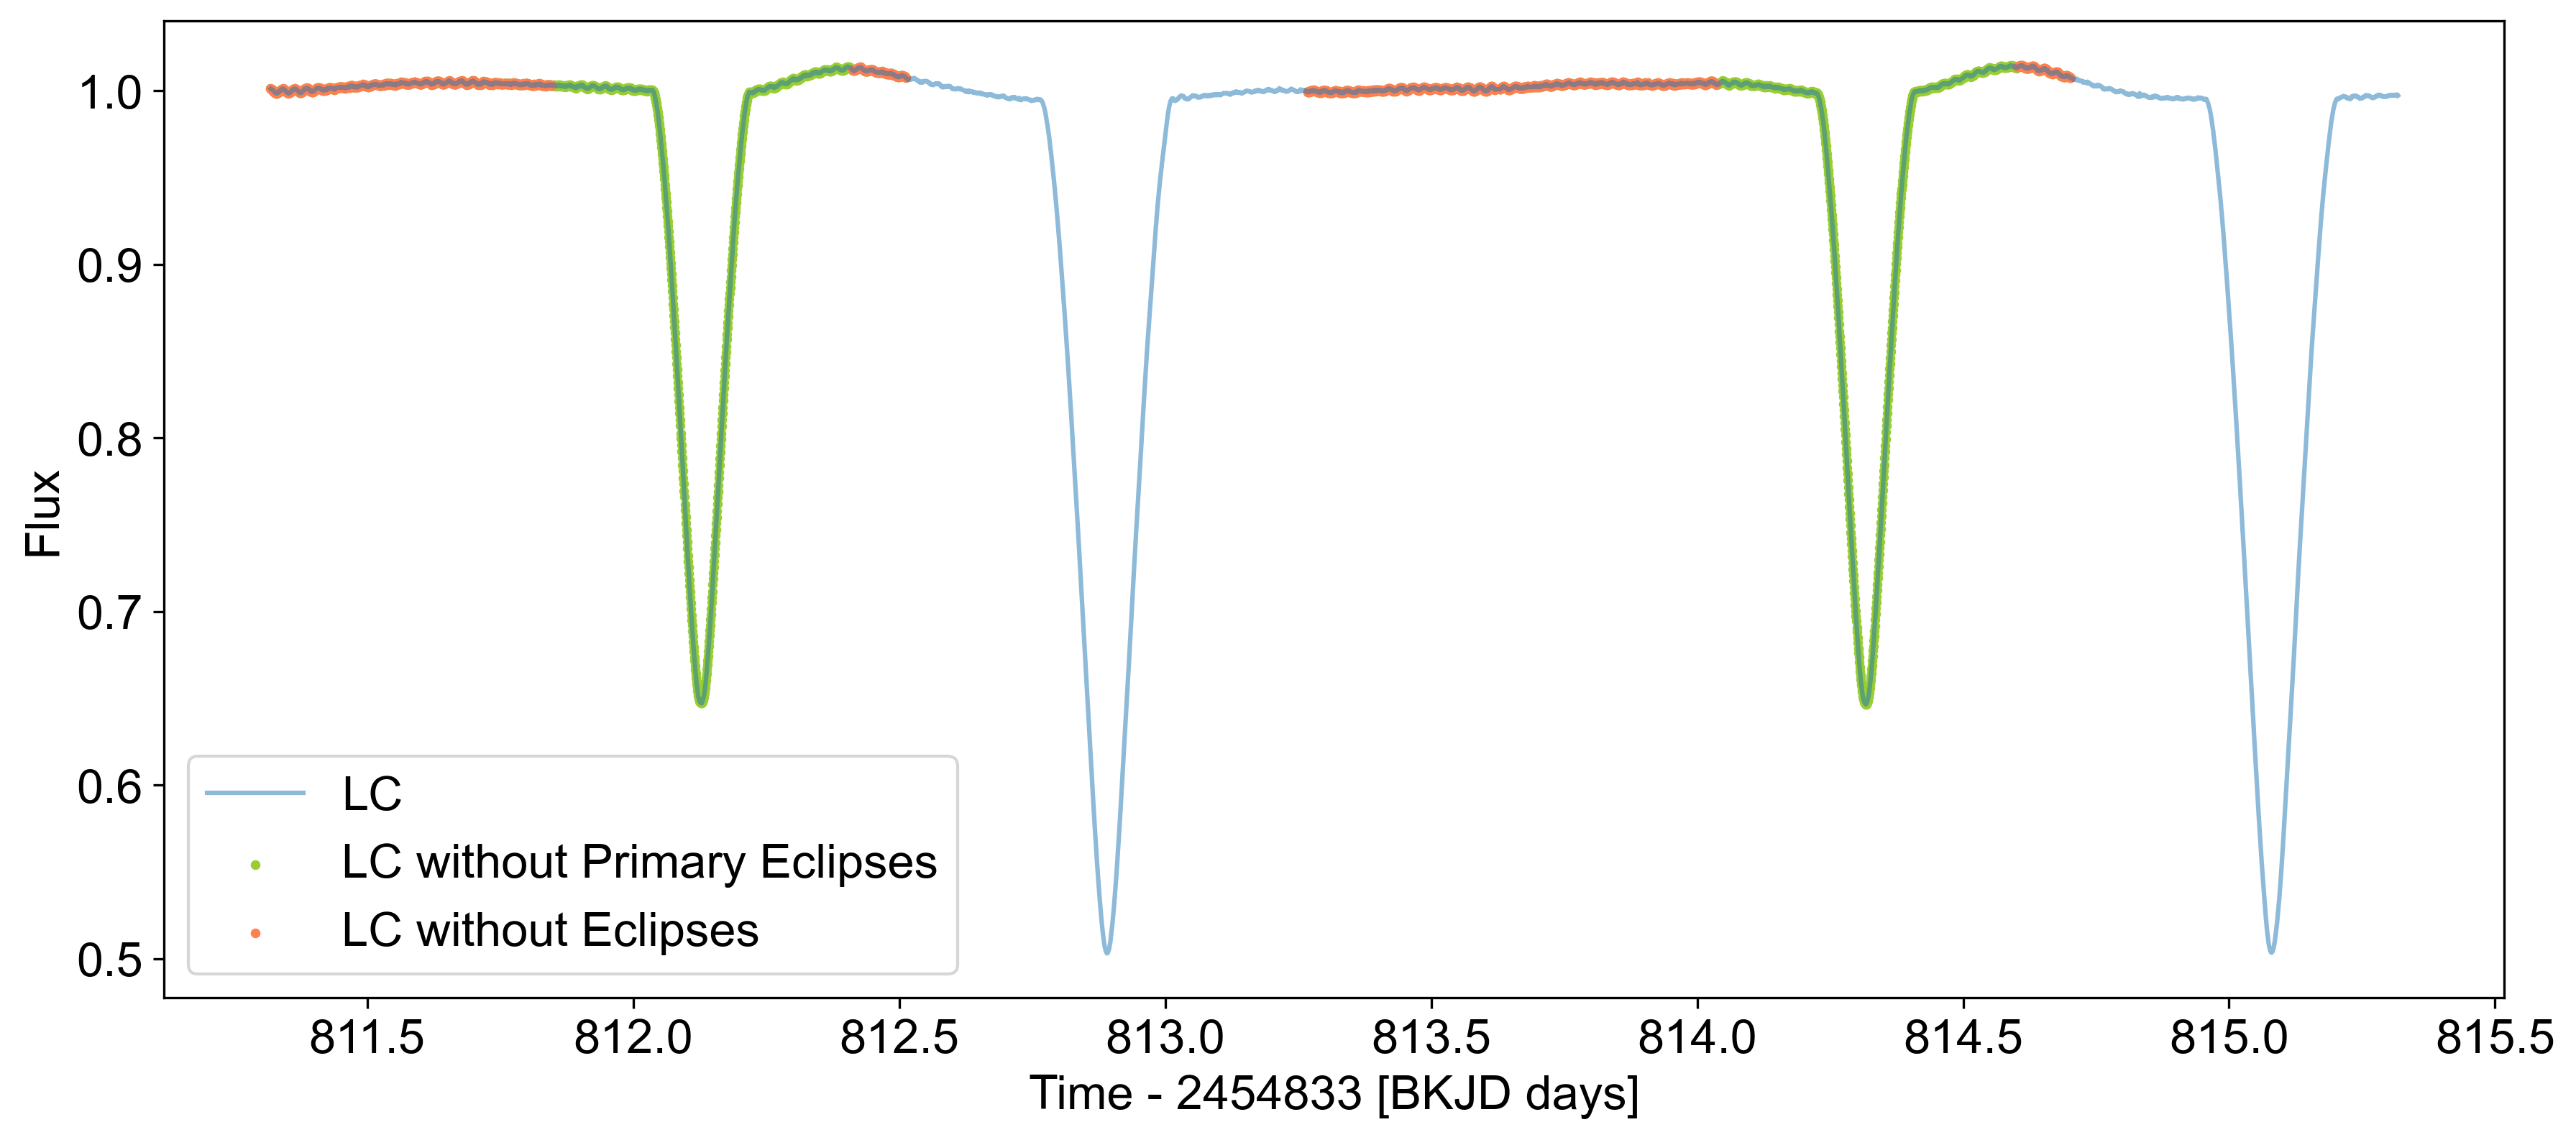

In [14]:
fig, ax = plt.subplots(1,1)
lc_primary_masked.scatter(c='yellowgreen', s=5, ax=ax,label = 'LC without Primary Eclipses')
lc_wo_eclipses.scatter(c='coral', s=5, ax=ax,label = 'LC without Eclipses')
cut_lc.plot(ax=ax,alpha=0.5,lw=1.5,label='LC') 
ax.legend(loc='lower left')

# Estimate the Rotation Period of the Primary Star

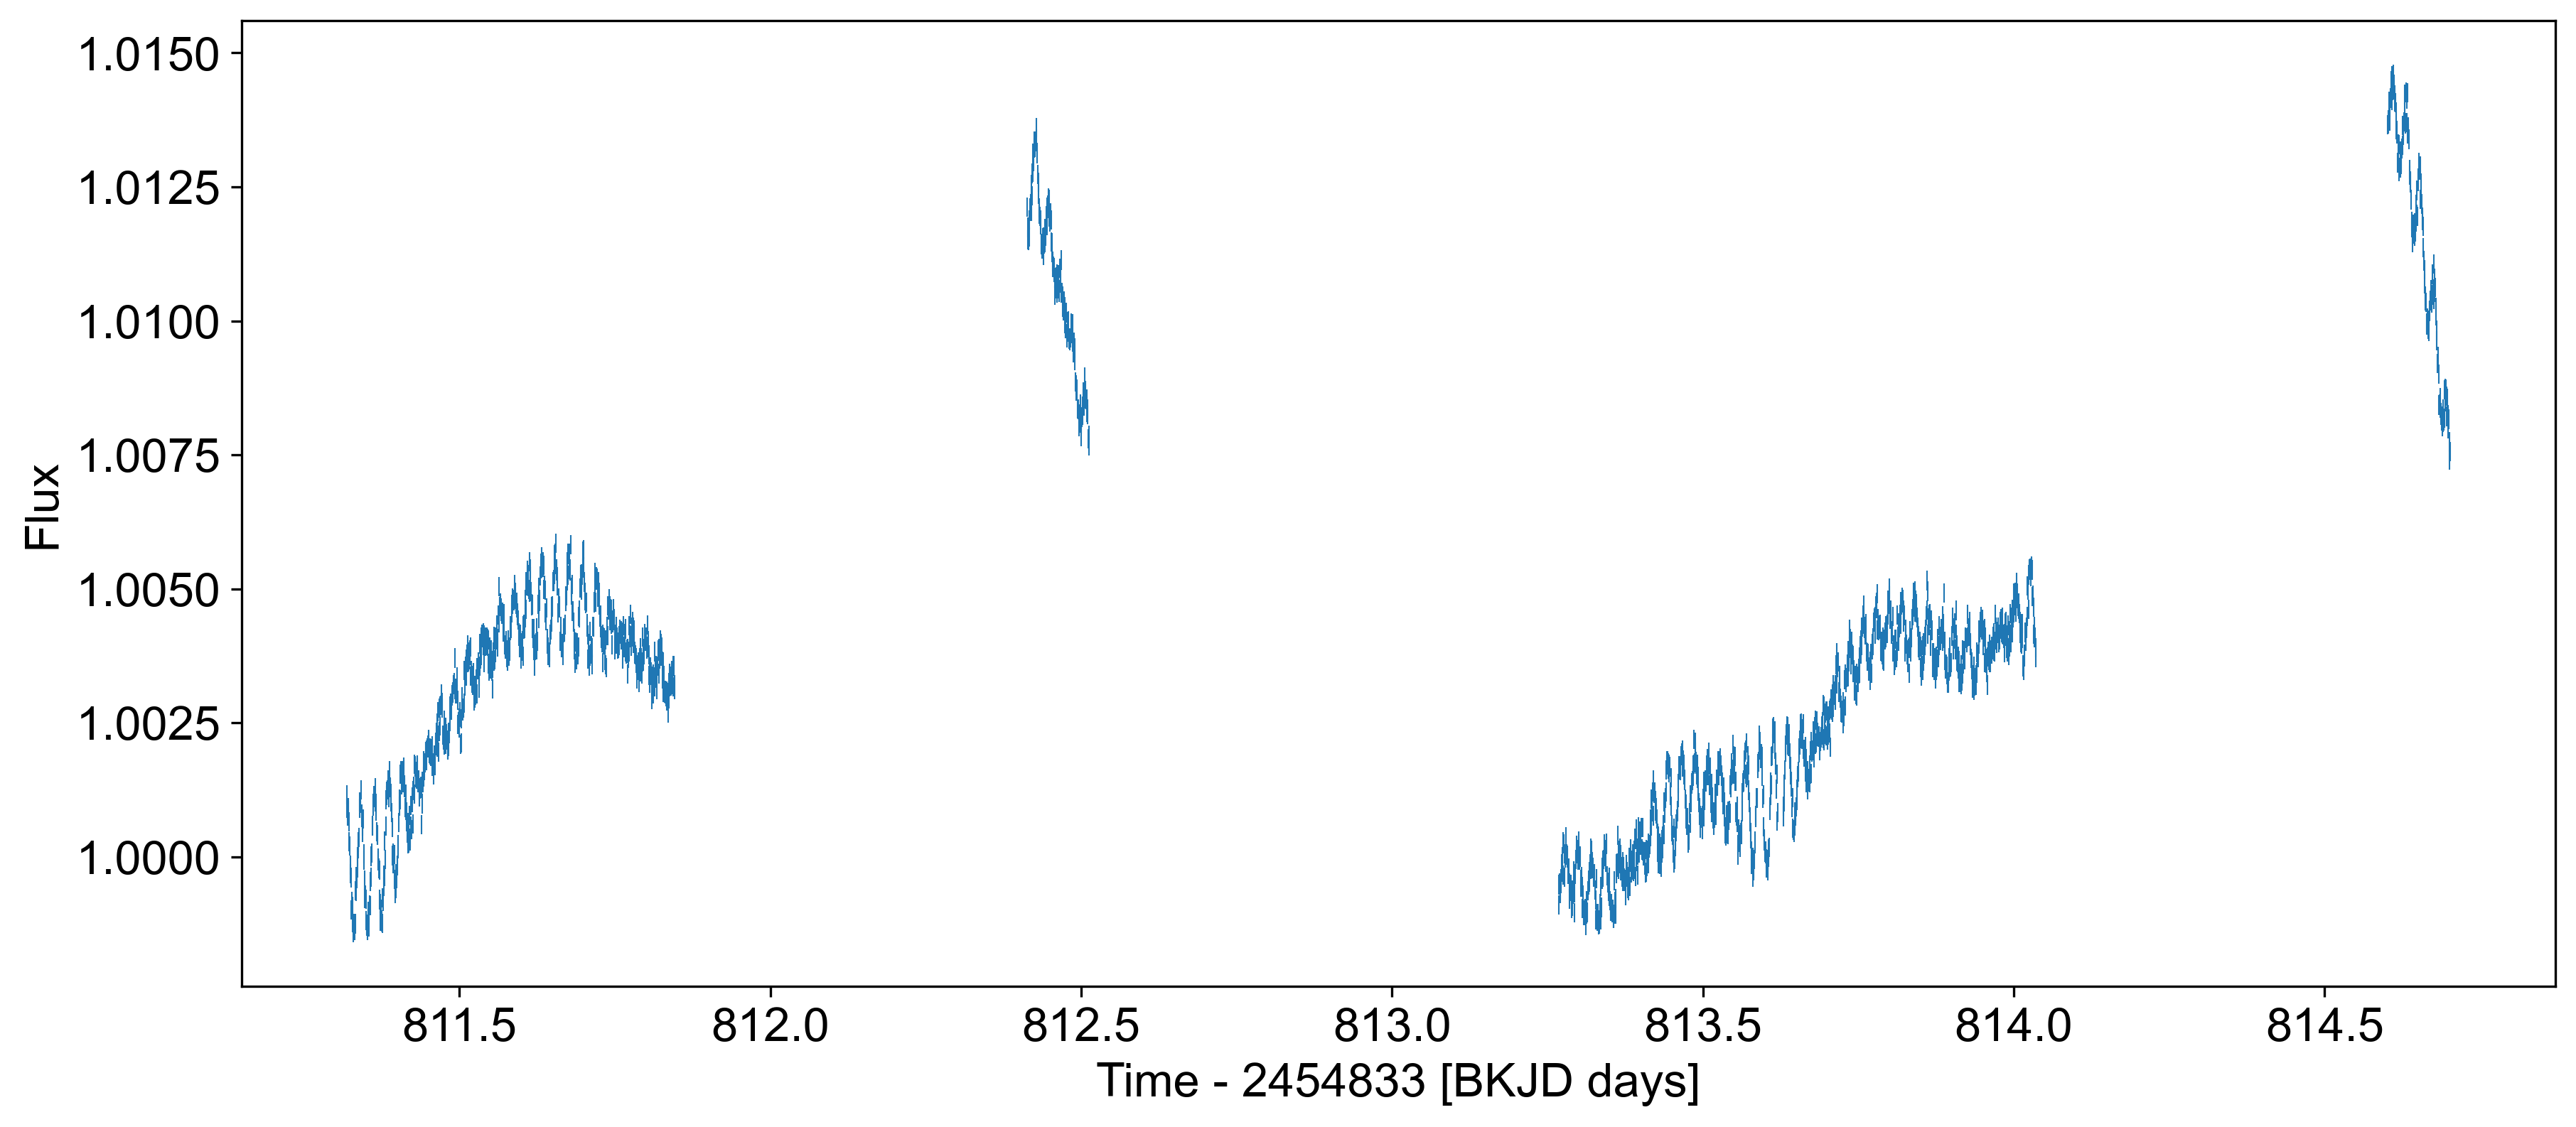

In [15]:
fig, ax = plt.subplots(1,1)
lc_wo_eclipses.errorbar(ax=ax)
#fig.savefig('figures/oot.png')

No handles with labels found to put in legend.


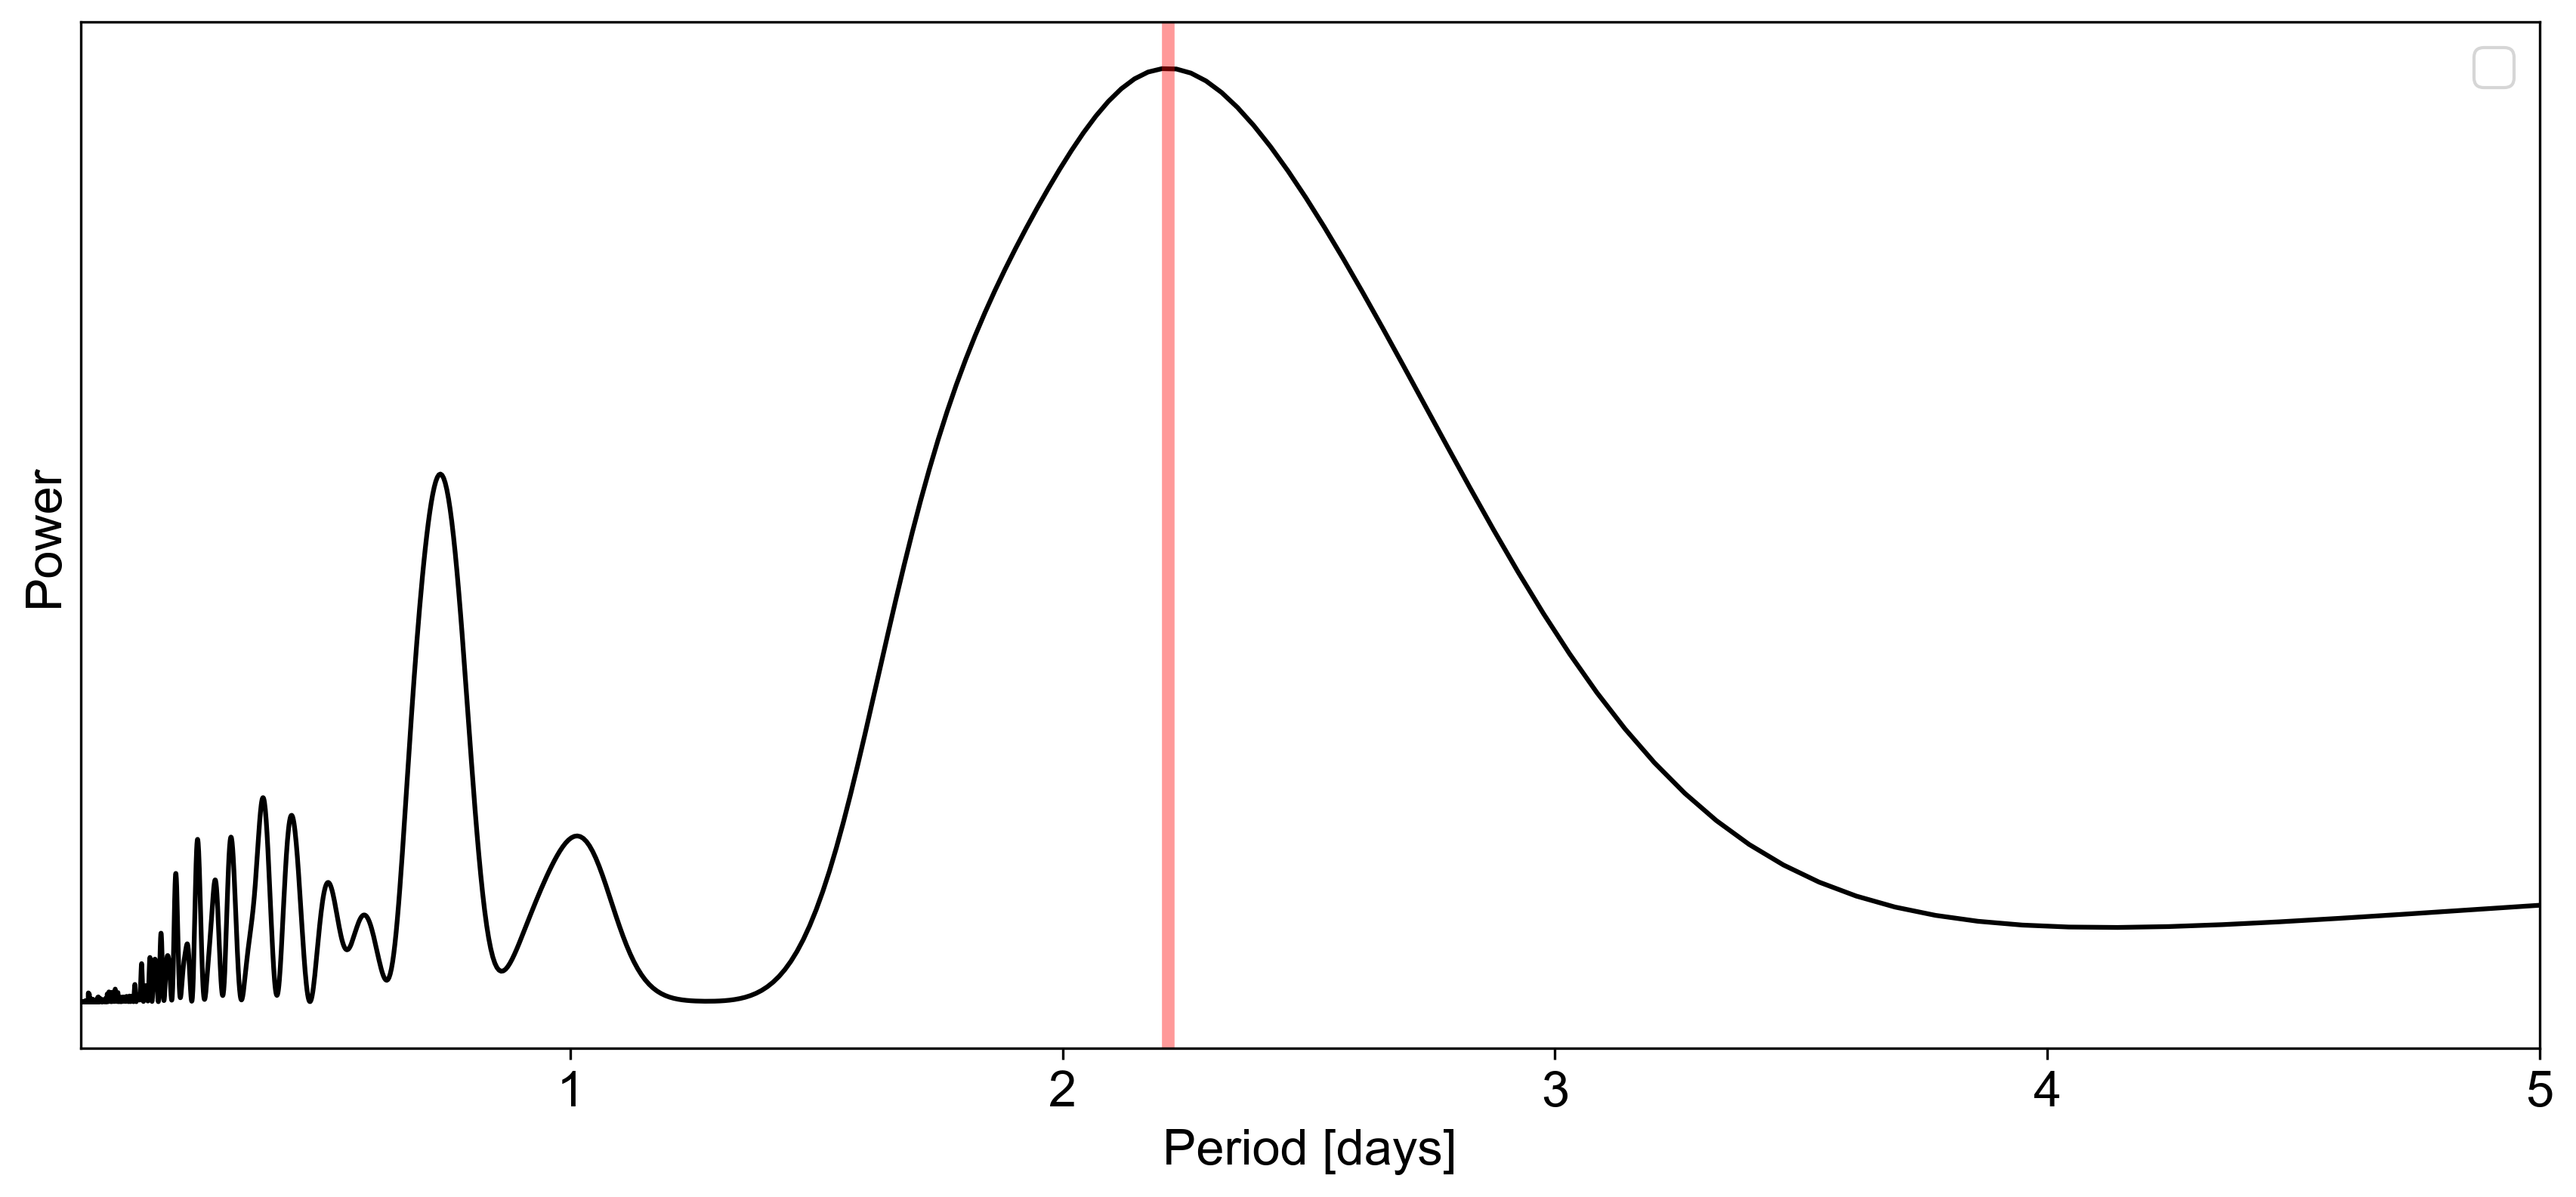

In [16]:
results = xo.estimators.lomb_scargle_estimator(
    lc_wo_eclipses.time, lc_wo_eclipses.flux,
    max_peaks=2, 
    min_period=0.005, 
    max_period=5, 
    samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
fig, ax = plt.subplots(1,1)
ax.plot(1 / freq, power, "k")
ax.axvline(peak["period"], color="red", lw=4, alpha=0.4)
ax.set(xlim=((1 / freq).min(), (1 / freq).max()), xlabel="Period [days]", ylabel="Power")
ax.set_yticks([])
ax.legend(loc='upper right');
#fig.savefig('figures/oot_periodogram.png')

({'index': 233,
  'log_power': -6.420529950135105,
  'period': 0.7362728033522385,
  'period_uncert': 0.05748785095469451},
 {'index': 507,
  'log_power': -6.848625076376095,
  'period': 0.3663990704292435,
  'period_uncert': 0.013454261675663362})

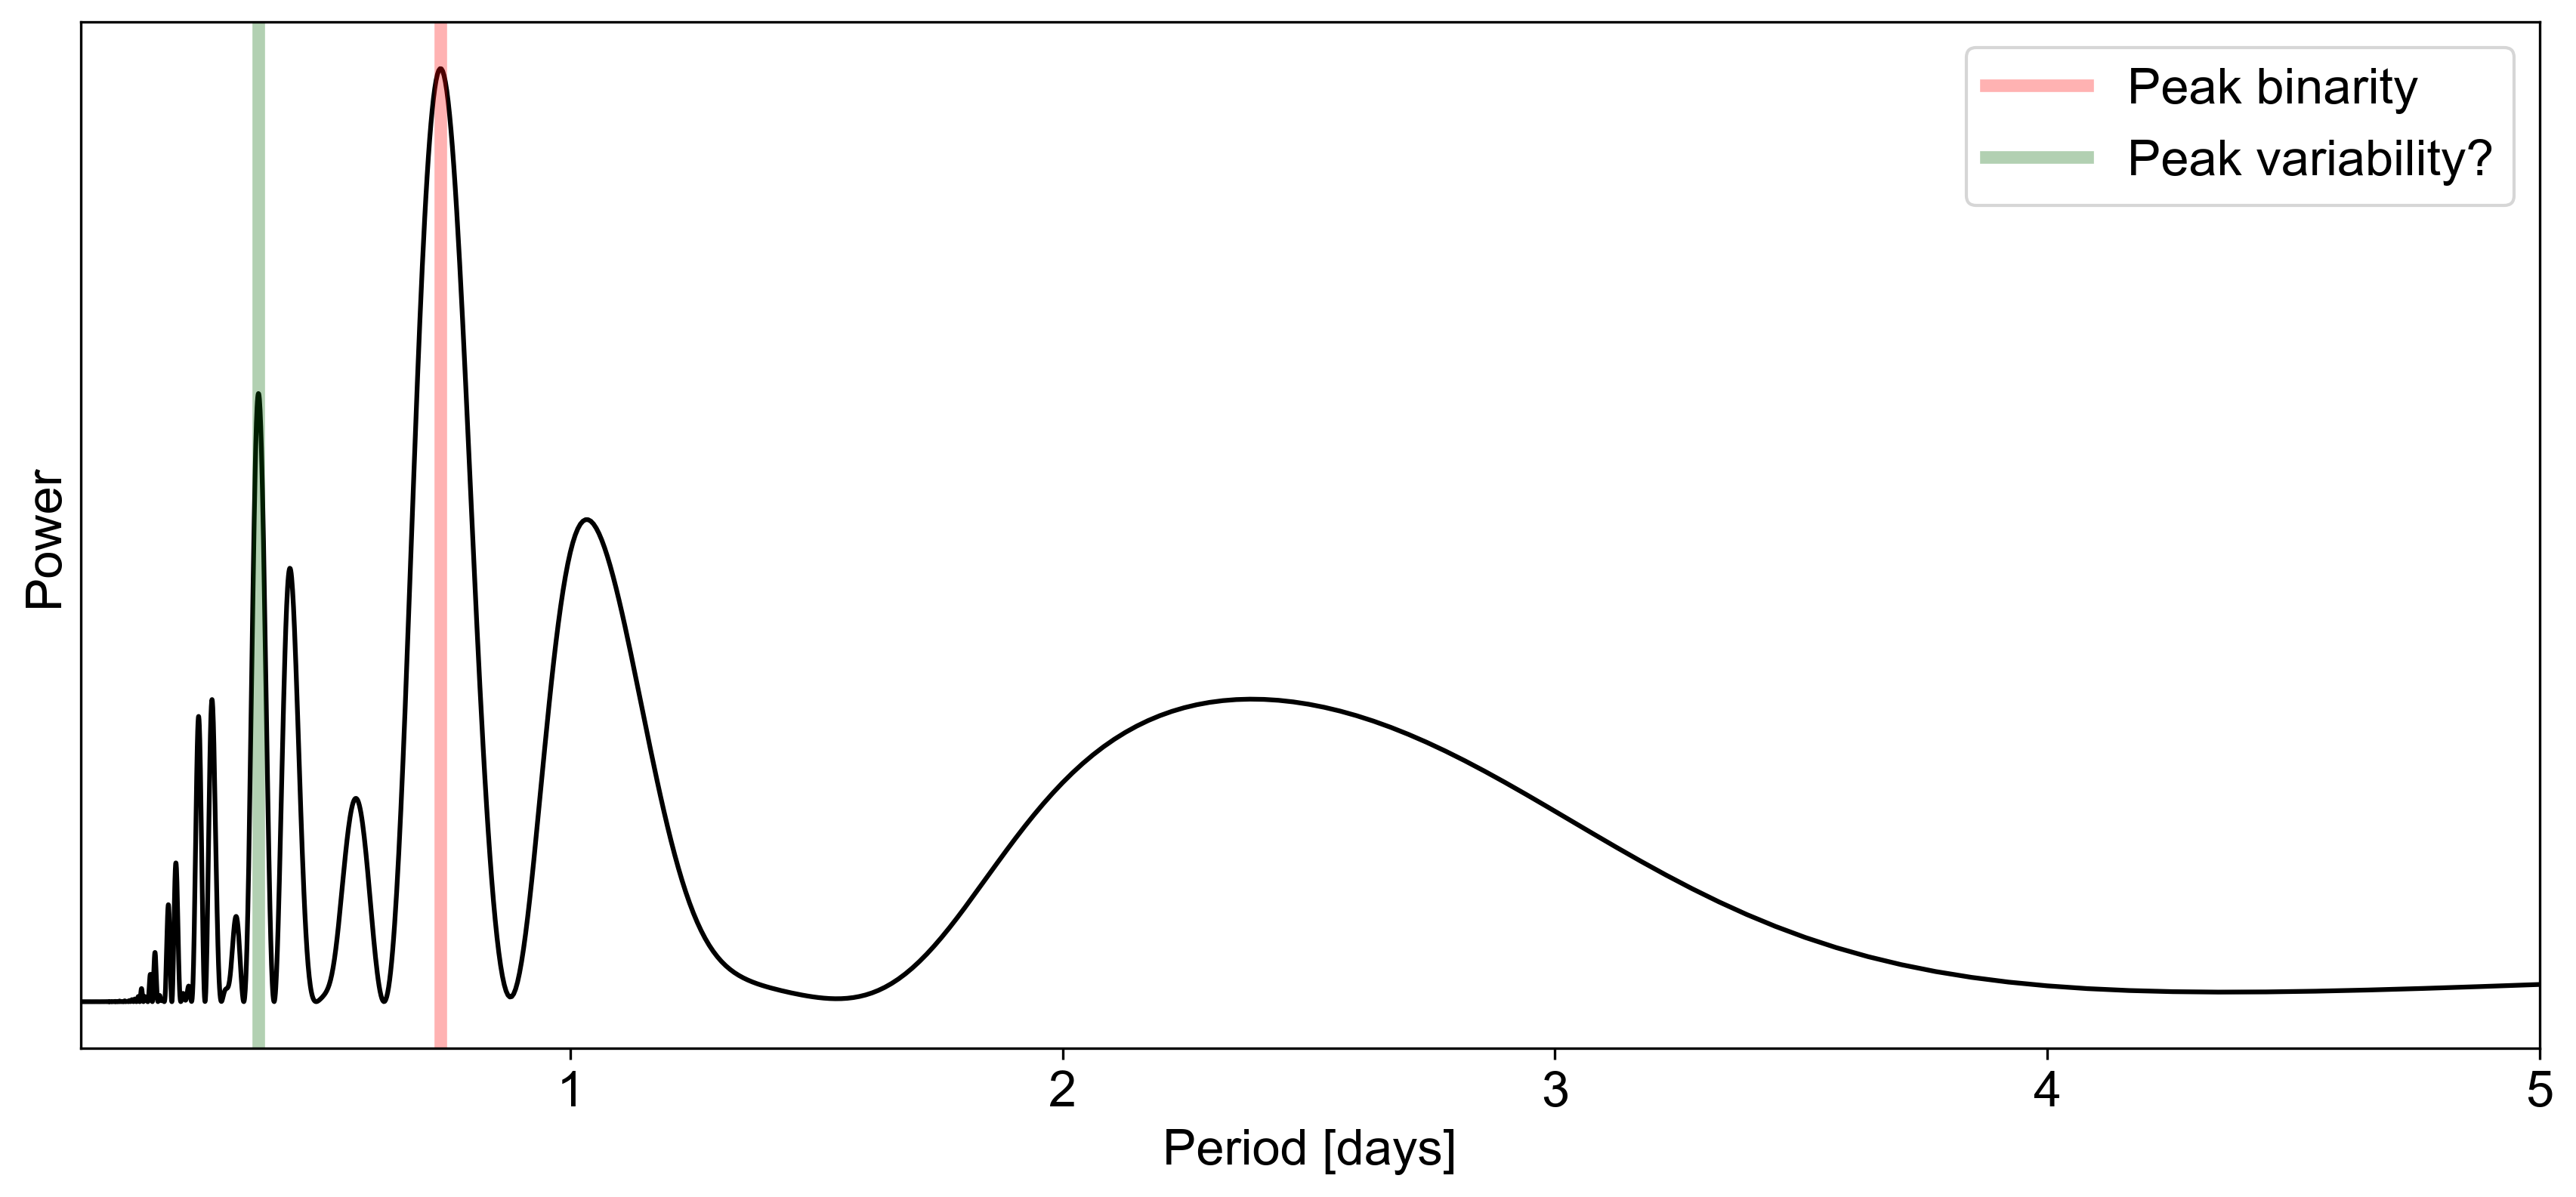

In [17]:
results = xo.estimators.lomb_scargle_estimator(
    cut_lc.time, cut_lc.flux,
    max_peaks=2, 
    min_period=0.005, 
    max_period=5, 
    samples_per_peak=50
)

peak = results["peaks"][0]
peak_var = results["peaks"][1]
freq, power = results["periodogram"]
fig, ax = plt.subplots(1,1)
ax.plot(1 / freq, power, "k")
ax.axvline(peak["period"], color="red", lw=4, alpha=0.3, label = 'Peak binarity')
ax.axvline(peak_var["period"], color="darkgreen", lw=4, alpha=0.3, label = 'Peak variability?')
ax.set(xlim=((1 / freq).min(), (1 / freq).max()), xlabel="Period [days]", ylabel="Power")
ax.set_yticks([])
ax.legend(loc='upper right');
peak, peak_var

# Probabilistic Model

We will define the probabilistic model using `PyMC3` and `exoplanet` to fit the eclipses and account for noise & stellar variability. After defining such model, we will iteratively clip outliers in the LC using sigma clipping and then estimate the maximum a posteriori parameters.

We will treat the stars as spherical and fit an eccentric orbit instead of fixing the eccentricity to zero. We will model the phase curve, stellar variability and residual systematics/drifts/other effects with Gaussian Processes. In particular, we will fit the LC with 2 GP kernels: a simple harmonic oscillator to describe the non-periodic variability, and a rotation kernel to describe rotation+pulsations. We will generate the model LC with `starry`, based on the distributions for the LD coefficients and the surface brigthness ratio of the secondary relative to the primary. 

Some notes about `pymc3`: 

* LogNormal is oly defined for positive values (similarly to gamma and inverse gamma). This isn't the case for normal.
* `Deterministic` distributions: They can be useful because they allow us to track values as the chain progresses, even if they're not parameters. 
* `gp.GP`: The interface for computing GP models with $\texttt{celerite}$. This class implements the method described in Foreman-Mackey et al. (2017) and Foreman-Mackey (2018) for scalable evaluation of Gaussian Process (GP) models in 1D. Terms: 
    - `kernel` : Specifies the GP kernel.
    - `x`: Input coordinates. This should be a 1D array and the elements must be sorted. Otherwise the results are undefined.
    - `diag`: Extra diagonal to add to the covariance matrix. This should have the same length as `x` and correspond to the excess variance for each data point.
    - `mean` : Mean function for the GP. This can be a constant scalar value or a callable that will be called with a single, one dimensional tensor argument specifying the input coordinates where the mean should be evaluated.

1.00367

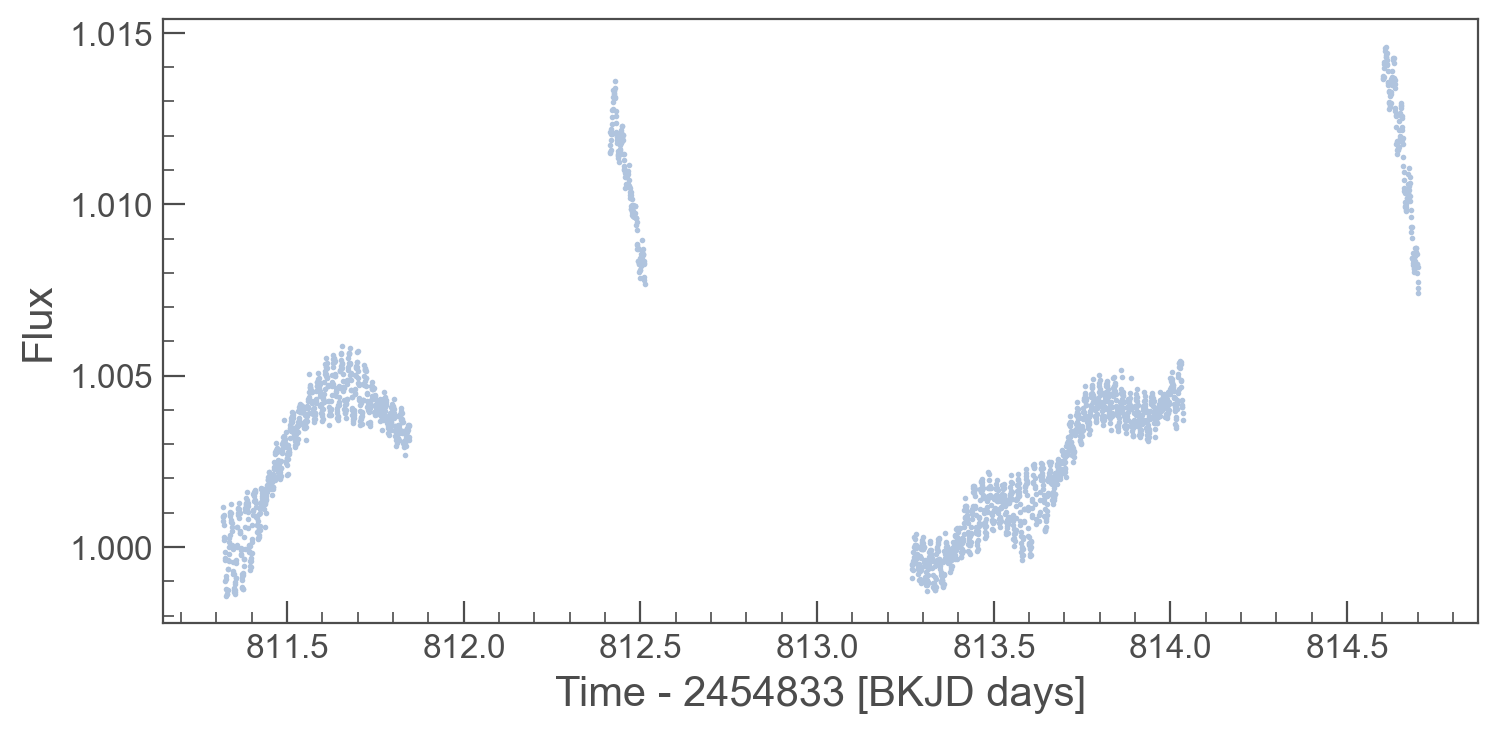

In [18]:
lc_wo_eclipses.scatter(c=c_lc)
np.mean(lc_wo_eclipses.flux)

In [24]:
with pm.Model() as model_full:
    
        ########################## SIGNAL 1: BASELINE FLUX #########################
        mean_lc = pm.Normal("mean_lc", mu=0.0, sigma=np.mean(lc_wo_eclipses.flux))  
        
        ########################## SIGNAL 2: ECLIPSES #########################
        
        # Primary star
        M1 = pm.Lognormal("M1", mu=1.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=R_A, sigma=10.0)

        
        # Secondary ratios
        k = pm.Lognormal("k", mu=R_B/R_A, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Secondary star
        M2 = pm.Deterministic("M2", q * M1)
        R2 = pm.Deterministic("R2", k * R1)

        # Orbital Parameters 
        b = xo.ImpactParameter("b", ror=k, testval=1.5) 
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0) 

        # Eccentricity Parameters: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.01])) 
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0])) #arguments of periastron for the orbits in radians.

        # Keplerian orbit for the EB
        orbit = xo.orbits.KeplerianOrbit(
            r_star=R1,
            m_star=M1,
            m_planet=M2,
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega, 
            b=b
        )

        # Track some other orbital elements 
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
            
        # Set up the LC secondary eclipse model computed using starry
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s) 
        
        def model_lc(t):
            return (mean_lc + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0])
        
        ######################### SIGNAL 3: NOISE/STELLAR PULSATIONS/ROTATION #########################
        
        #A jitter term describing excess white noise
        logs2 = pm.InverseGamma("logs2", testval=1.0,**xo.estimate_inverse_gamma_parameters(0.1, 10.0))        

        # Terms to describe non-periodic variability
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(lc_mcmc.flux)), sd=10.0)
        logw0 = pm.Normal("logw0", mu=np.log(lit_period), sd=10.0) #mu=np.log(2 * np.pi / 10), sd=5.0)
        kernel_sho = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1/np.sqrt(2))
        
        # Parameters to describe RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(lc_mcmc.flux)), sd=10.0)
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
        logP_var = BoundedNormal("logP_var", mu=np.log(peak_var["period"]), sd=5.0)
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = xo.distributions.UnitUniform("mix")

        # Set up the GP model: SHO + rotation term
        kernel_lc = kernel_sho + xo.gp.terms.RotationTerm(
            log_amp=logamp,  
            period=tt.exp(logP_var), 
            log_Q0=logQ0,    
            log_deltaQ=logdeltaQ, 
            mix=mix
        )
        
        # GP observation model:
        gp_lc = xo.gp.GP(
            kernel_lc, 
            lc_mcmc.time,
            tt.exp(logs2)**2+tt.zeros(lc_mcmc.time.size),
            mean=model_lc)
        
        # Compute the GP likelihood 
        gp_lc.marginal("obs_lc", observed=lc_mcmc.flux)
        #pm.Potential('gp', gp_lc.log_likelihood(lc_mcmc.flux-model_lc(lc_mcmc.time)))
        pm.Deterministic("gp_pred", gp_lc.predict()) #GP signal prediction
        
        model_full.x = x
        model_full.y = y
        model_full.gp_lc = gp_lc
        model_full.model_lc = model_lc

## Optimize MAP estimates

In [25]:
def get_map_soln(data, model, start=None):
    with model:
        if start is None:
            start = model.test_point
            
        # Double check that everything looks good - we shouldn't see any NaNs!
        print(model.check_test_point())
         
        map_soln = xo.optimize(start=start)
        map_soln = xo.optimize(start=map_soln, vars=[mean_lc, R1, k, s, b])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[mean_lc, logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[t0, period])
        
    return map_soln

In [26]:
map_soln = get_map_soln(lc_mcmc, model_full)
map_soln

mean_lc                        -0.92
M1_log__                       -3.22
R1_log__                       -3.22
k_log__                        -3.22
q_log__                        -3.22
s_log__                        -3.22
b_impact__                     -1.39
period_log__                   -0.92
t0                             -0.92
ecs_unitdisk+interval__        -1.39
u1_quadlimbdark__              -2.77
u2_quadlimbdark__              -2.77
logs2_log__                    -1.30
logSw4                         -3.22
logw0                          -3.22
logamp                         -3.22
logP_var_interval__            -2.73
logQ0                          -3.22
logdeltaQ                      -3.22
mix_logodds__                  -1.39
obs_lc                    -120713.31
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [mix, logdeltaQ, logQ0, logP_var, logamp, logw0, logSw4, logs2, u2, u1, ecs, t0, period, b, s, q, k, R1, M1, mean_lc]


message: NaN result encountered.
logp: -120762.01657218226 -> -120762.01657218226
optimizing logp for variables: [b, k, s, R1, mean_lc]


message: NaN result encountered.
logp: -120762.01657218226 -> -120762.01657218226
optimizing logp for variables: [mix, logdeltaQ, logQ0, logP_var, logamp, logw0, logSw4, logs2, u2, u1, ecs, t0, period, b, s, q, k, R1, M1, mean_lc]


message: NaN result encountered.
logp: -120762.01657218226 -> -120762.01657218226
optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]


message: NaN result encountered.
logp: -120762.01657218226 -> -120762.01657218226
optimizing logp for variables: [mix, logdeltaQ, logQ0, logP_var, logamp, logw0, logSw4, logs2, u2, u1, ecs, t0, period, b, s, q, k, R1, M1, mean_lc]


message: NaN result encountered.
logp: -120762.01657218226 -> -120762.01657218226
optimizing logp for variables: [logw0, logSw4, logs2, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -120762.01657218226 -> -7237.717776428712
optimizing logp for variables: [period, t0]


message: NaN result encountered.
logp: -7237.717776428712 -> -7237.717776428712


{'mean_lc': array(-0.00903187),
 'M1_log__': array(1.),
 'R1_log__': array(2.416),
 'k_log__': array(0.65397351),
 'q_log__': array(0.),
 's_log__': array(-0.69314718),
 'b_impact__': array(0.05258016),
 'period_log__': array(0.78348927),
 't0': array(121.135787),
 'ecs_unitdisk+interval__': array([2.00000000e-05, 2.00006667e-02]),
 'u1_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]),
 'u2_quadlimbdark__': array([4.4408921e-16, 0.0000000e+00]),
 'logs2_log__': array(-4.55932178),
 'logSw4': array(16.5456937),
 'logw0': array(2.22059991),
 'logamp': array(9.3971654),
 'logP_var_interval__': array(0.),
 'logQ0': array(1.),
 'logdeltaQ': array(2.),
 'mix_logodds__': array(0.),
 'M1': array(2.71828183),
 'R1': array(11.20096572),
 'k': array(1.92316739),
 'q': array(1.),
 's': array(0.5),
 'M2': array(2.71828183),
 'R2': array(21.54133204),
 'b': array(1.5),
 'period': array(2.1890973),
 'ecs': array([1.e-05, 1.e-02]),
 'ecc': array(0.01),
 'omega': array(1.56979633),
 'incl': array

## Simulate the Data that We Will Fit

At the model's best fit parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.

In [27]:
with model_full:
    gp_pred = xo.eval_in_model(model_full.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model_full.model_lc(model_full.x), map_soln) - map_soln["mean_lc"]

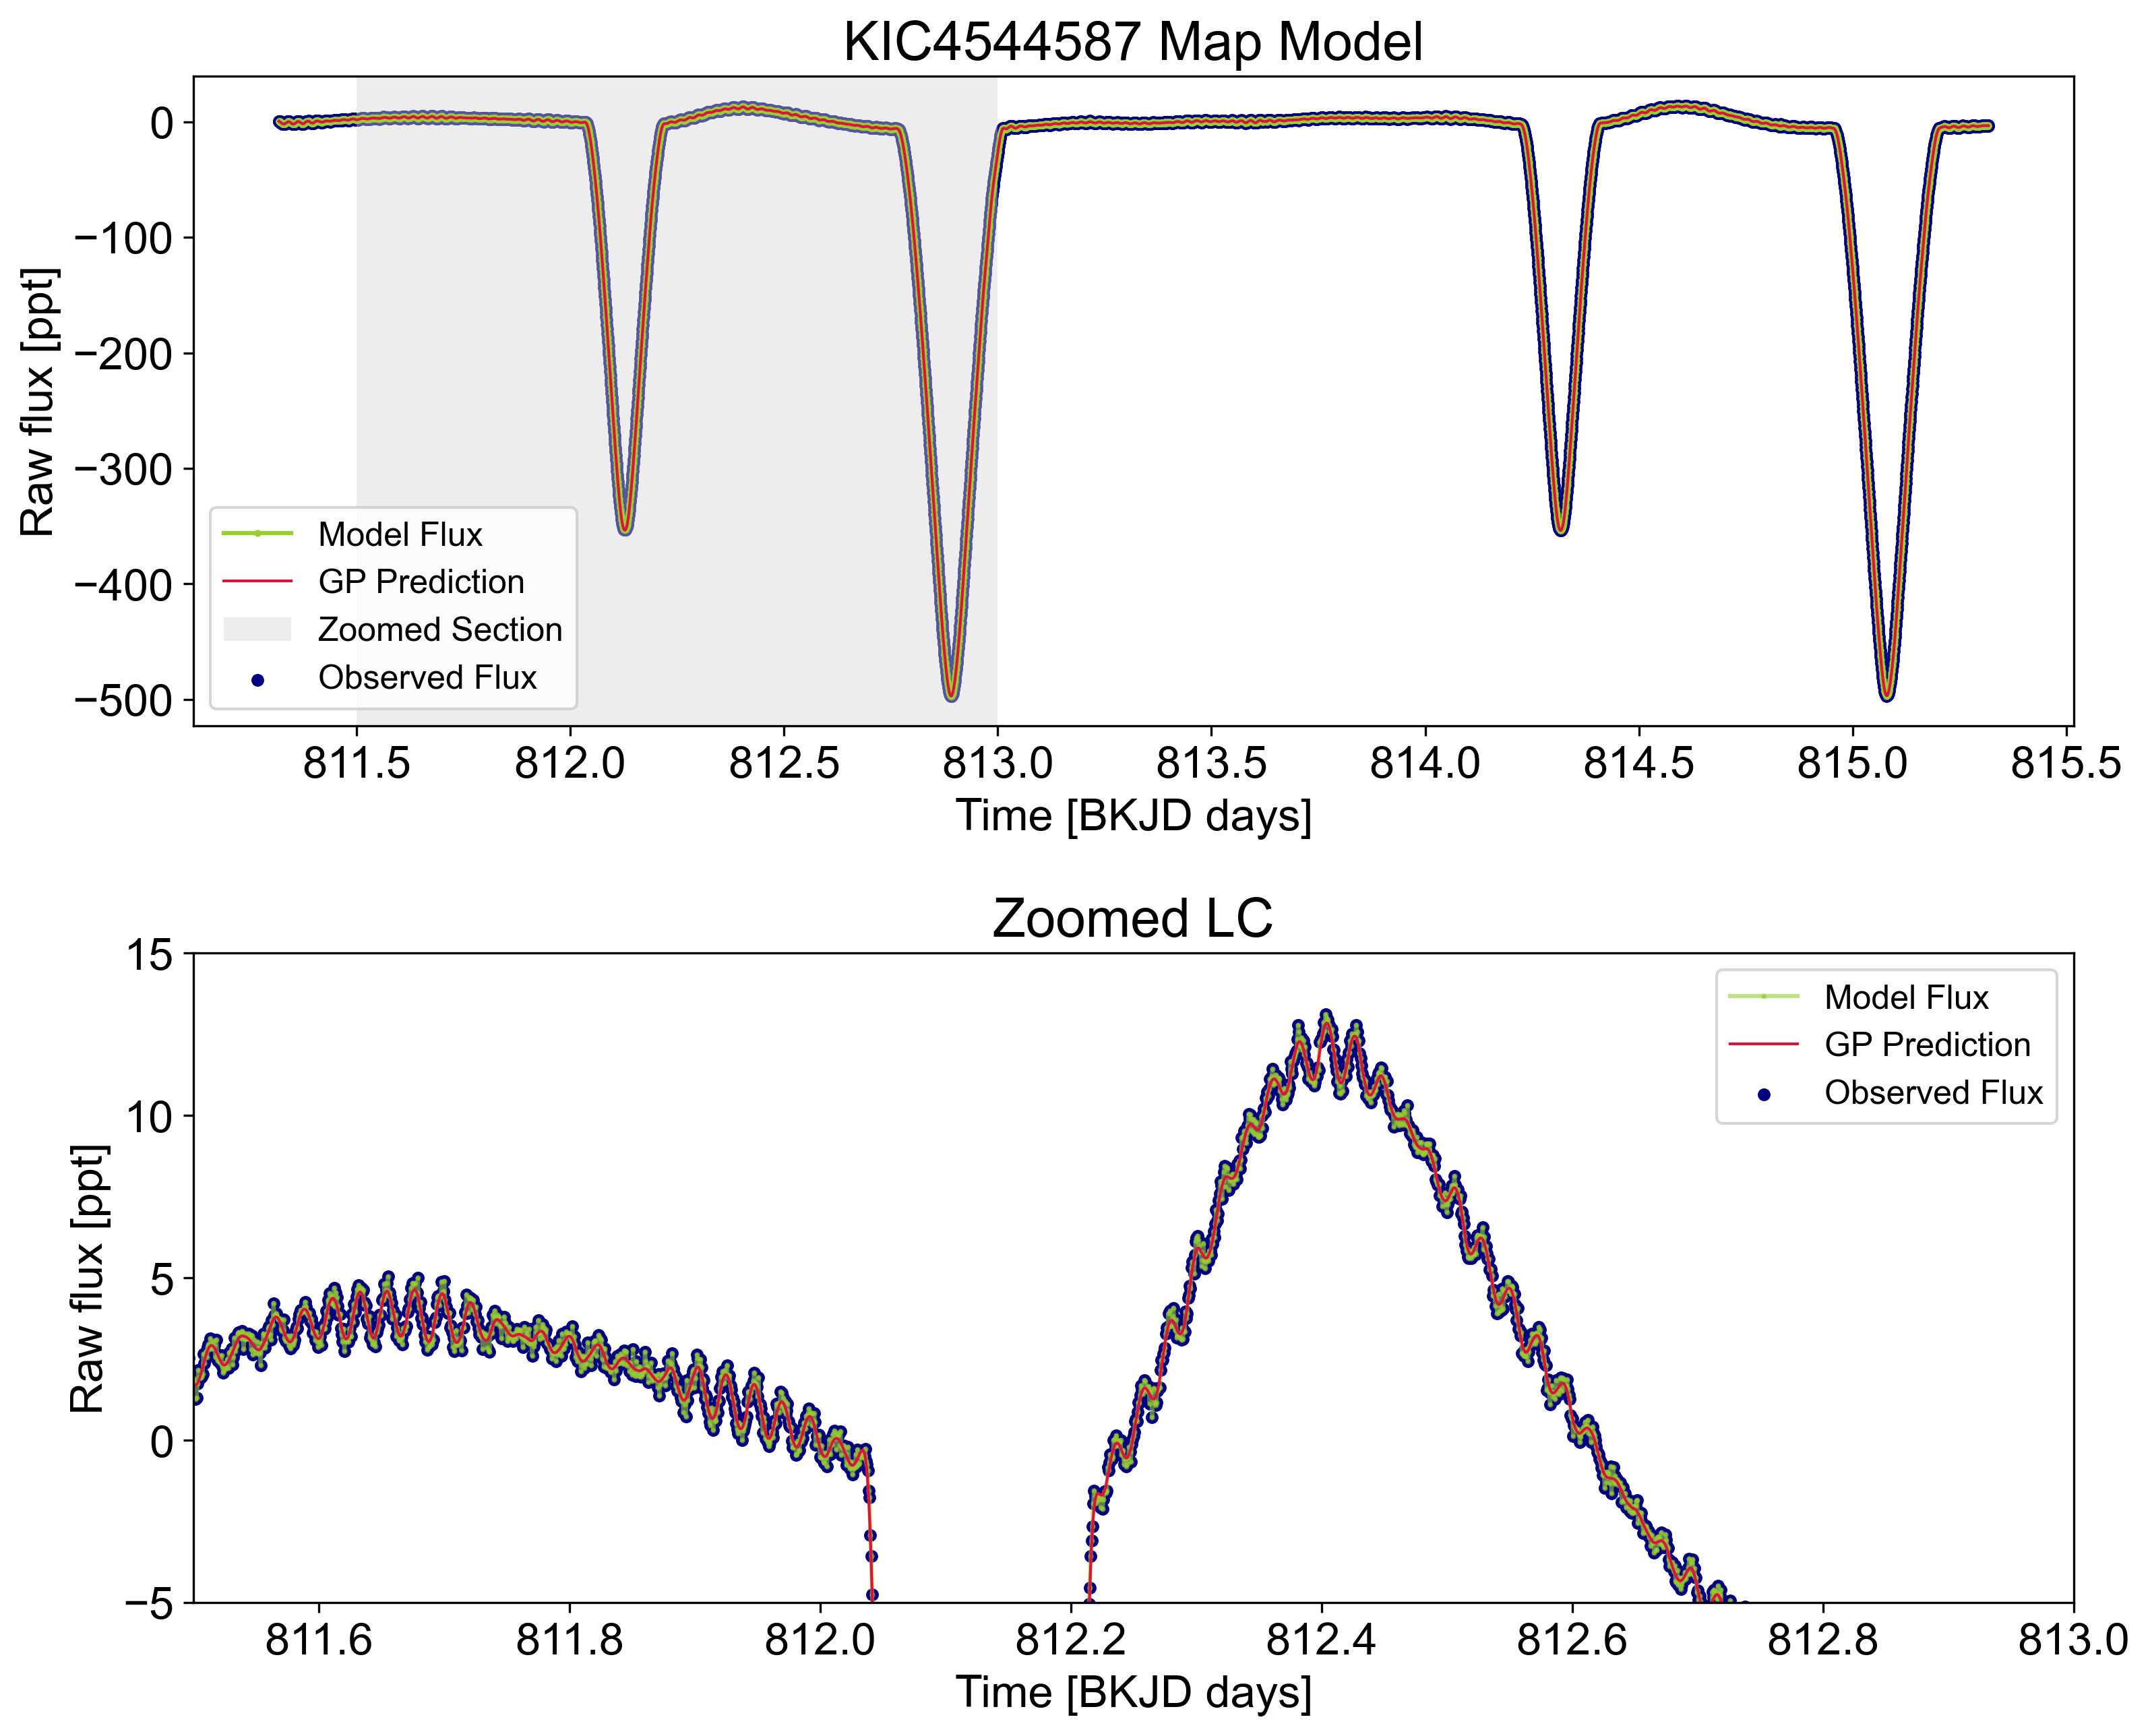

In [28]:
low_lim = 811.5
up_lim = 813

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,10))
fig.subplots_adjust(hspace=0.35)
ax1.scatter(x, y, c='navy', marker='.', s=50, label = 'Observed Flux')
ax1.plot(model_full.x, model_full.y, c='yellowgreen', marker='o', ms=1.5, label = 'Model Flux')
ax1.plot(model_full.x, gp_pred, color="crimson", lw=1, label = 'GP Prediction')
ax1.set(xlabel = "Time [BKJD days]", ylabel = "Raw flux [ppt]",title='KIC%s Map Model'%KIC);
ax1.axvspan(low_lim,up_lim,facecolor='lightgrey',alpha=0.4,label='Zoomed Section')
ax1.legend(loc='lower left',fontsize=12);

ax2.scatter(x, y, c='navy', marker='.', s=50, label = 'Observed Flux')
ax2.plot(model_full.x, model_full.y, c='yellowgreen', marker='o',alpha=0.6, ms=1, label = 'Model Flux')
ax2.plot(model_full.x, gp_pred, color="crimson", lw=1, label = 'GP Prediction')
ax2.set(xlabel = "Time [BKJD days]", ylabel = "Raw flux [ppt]", title = 'Zoomed LC',
        xlim=(low_lim,up_lim), ylim=(-5,15));
ax2.legend(loc='upper right',fontsize=12); 

#fig.savefig('figures/map_model.png')

## Sampling


In [ ]:
np.random.seed(23642)

with model_f:
    trace = xo.sample(
        tune=500,
        draws=1000, #steps 
        start=map_soln,
        cores = 7, #chains || If None, set to the number of CPUs in the system, but at most 4.
        chains = 7, #walkers || If None, then set to either cores or 2, whichever is larger.
        step=xo.get_dense_nuts_step(target_accept=0.95) #target_accept=0.95,#
)

In [ ]:
idata = az.from_pymc3(trace) #model=model) # dims=dims, coords=coords
idata.to_netcdf('results.nc')

In [ ]:
az.summary(idata)

In [ ]:
pm.model_graph.model_to_graphviz(model)

Now since we now have samples, let’s make some diagnostic plots. The first plot to look at is the “traceplot” implemented in PyMC3. In this plot, you’ll see the marginalized distribution for each parameter on the left and the trace plot (parameter value as a function of step number) on the right. In each panel, you should see two lines with different colors. These are the results of different independent chains and if the results are substantially different in the different chains then there is probably something going wrong.

In [ ]:
pm.traceplot(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

After sampling, it’s important that we assess convergence. We can do that using the pymc3.summary function, which provides convergence diagnostics for some of the key parameters.

In [ ]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

In [ ]:
period_samples = trace["Mperiod"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

In [ ]:
az.plot_posterior(idata, var_names="M1") #coords={"planet": ["55 Cnc e", "Kepler-37 c"]});

In [ ]:
az.plot_pair(idata, var_names=["M1", "R1", "ecs"], kind="kde", fill_last=False);

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

In [ ]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901) (shown as blue crosshairs).
The orange contours in this figure show the results transformed to a uniform prior on eccentricity as discussed below.
These contours are provided to demonstrate (qualitatively) that these inferences are not sensitive to the choice of prior.

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
weights = 1.0 / trace["ecc"]
weights *= len(weights) / np.sum(weights)
fig = corner.corner(samples, weights=weights, plot_datapoints=False, color="C1")
_ = corner.corner(samples, fig=fig) #truths=[1.727, 1.503, 2.203, 1.5488], 

# Other Tutorial Sections

## A note about eccentricities

If you looked closely at the model defined above, you might have noticed that we chose a slightly odd eccentricity prior: $p(e) \propto e$.
This is implied by sampling with $e\,\cos\omega$ and $e\,\sin\omega$ as the parameters, as has been discussed many times in the literature.
There are many options for correcting for this prior and instead assuming a uniform prior on eccentricity (for example, sampling with $\sqrt{e}\,\cos\omega$ and $\sqrt{e}\,\sin\omega$ as the parameters), but you'll find much worse sampling performance for this problem if you try any of these options (trust us, we tried!) because the geometry of the posterior surface becomes much less suitable for the sampling algorithm in PyMC3.
Instead, we can re-weight the samples after running the MCMC to see how the results change under the new prior.
Most of the parameter inferences are unaffected by this change (because the data are very constraining!), but the inferred eccentricity (and especially $e\,\sin\omega$) will depend on this choice.
The following plots show how these parameter inferences are affected.
Note, especially, how the shape of the $e\,\sin\omega$ density changes.

In [ ]:
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    label="$p(e) = e / 2$",
)
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e\,\sin(\omega)$")
plt.ylabel("$p(e\,\sin\omega\,|\,\mathrm{data})$")
plt.yticks([])
plt.legend(fontsize=12)

plt.figure()
plt.hist(trace["ecc"], 50, density=True, histtype="step", label="$p(e) = e / 2$")
plt.hist(
    trace["ecc"],
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e$")
plt.ylabel("$p(e\,|\,\mathrm{data})$")
plt.yticks([])
plt.xlim(0, 0.015)
_ = plt.legend(fontsize=12)

We can then use the `corner.quantile` function to compute summary statistics of the weighted samples as follows.
For example, here how to compute the 90% posterior upper limit for the eccentricity:

In [ ]:
weights = 1.0 / trace["ecc"]
print(
    "for p(e) = e/2: p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9])[0]
    )
)
print(
    "for p(e) = 1:   p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9], weights=weights)[0]
    )
)

Or, the posterior mean and variance for the radius of the primary:

In [ ]:
samples = trace["R1"]

print(
    "for p(e) = e/2: R1 = {0:.3f} ± {1:.3f}".format(np.mean(samples), np.std(samples))
)

mean = np.sum(weights * samples) / np.sum(weights)
sigma = np.sqrt(np.sum(weights * (samples - mean) ** 2) / np.sum(weights))
print("for p(e) = 1:   R1 = {0:.3f} ± {1:.3f}".format(mean, sigma))

As you can see (and as one would hope) this choice of prior does not significantly change our inference of the primary radius.